# Math behind neural networks

Based on this great YouTube video: https://www.youtube.com/watch?v=VMj-3S1tku0

<ins>Other good sources</ins><br>
- https://nnfs.io/
- https://www.youtube.com/watch?v=hfMk-kjRv4c

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Understanding derivatives

In [2]:
# define a quadratic function
def f(x):
    return 3*x**2 - 4*x + 5

# define its derivative
def df(x):
    return 6*x - 4

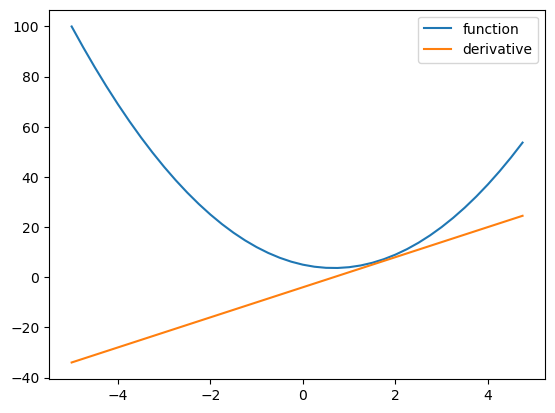

In [3]:
# plot the parabola & it's derivative
x = np.arange(-5, 5, 0.25)

y = f(x)
dy = df(x)

plt.plot(x, y, label='function')
plt.plot(x, dy, label='derivative')
plt.legend()

In [4]:
# derivative of a single point
h = 0.0001
a = 3.0

print((f(a + h) - f(a)) / h)    # ~ 14.0
print(df(a))                    # 14.0

14.000300000063248
14.0


### Idea behind derivatives

$\lim_{ h \to 0 } \frac{f(a+h)-f(a)}{h} $

If we bump up "a" a tiny amount "h", how much does the function go up or down. We normalize the rate of change through deviding by "h".

Effectivly this gives us the steepness at this point, which can be visualized as a tangent.

In [5]:
# complexer derivative
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
da = (a+h)*b + c
db = a*(b+h) + c
dc = a*b + (c+h)

print("d: ", d)
print("da: ", da)
print("da slope: ", (da-d)/h)
print("db: ", db)
print("db slope: ", (db-d)/h)
print("dc: ", dc)
print("dc slope: ", (dc-d)/h)

d:  4.0
da:  3.999699999999999
da slope:  -3.000000000010772
db:  4.0002
db slope:  2.0000000000042206
dc:  4.0001
dc slope:  0.9999999999976694


Calculating the derivative from the above function "d" in respect to "a, b, c" give us this:

$\frac{d}{da}[ab + c] = b = -3$

$\frac{d}{db}[ab + c] = a = 2$

$\frac{d}{dc}[ab + c] = 1$

## Training a neural network

In [6]:
# class for encapsulating & tracking math operations

class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0 # gradient zero has no effect on the output "L"
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")
        
        def _backward():
          self.grad += out.data * out.grad
        out._backward = _backward   
        return out

    def backward(self):       
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

In [7]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
d = Value(-2.0, label="d")

e = a*b; e.label="e"
f = e + c; f.label="f"
L = d * f; L.label = "L"

print(L, L._prev, L._op)

Value(data=-8.0) {Value(data=-2.0), Value(data=4.0)} *


In [8]:
# functions to visualizing the math operations of the "Value" class

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_graph(root):
  g = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    g.node(name = uid, label = "{ %s | val: %.4f | grad: %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      g.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      g.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    g.edge(str(id(n1)), str(id(n2)) + n2._op)

  return g

### Forwardpass

Our variables "a", "b", "c", "d" are plugged into a mathmatical expression which produces a single output "L". This is called "forward pass" & is visualized below.

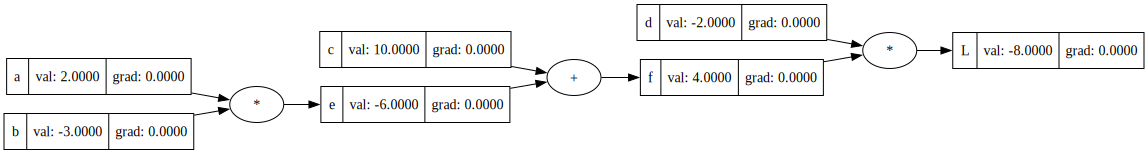

In [9]:
draw_graph(L)

### Backpropagation

Backpropagation starts at the last node ("L") and goes through all the steps in reverse order & calculates the gradient. This means calculating the derivative of each node (only weights & biases) with respect to "L".

<br>

#### Loss function

The loss function is a measurment to indicate how well the network performed. The smaller the loss the better the network performed. The "Mean Square Error" loss functions sums up the predicted values minus the actual values and squares them to get rid of the sign. 

<ins>MSE</ins><br>
$$
\begin{align}
& \mathcal{L} = \frac{1}{n}\sum_{i=1}^n(y-a)^2 \\
& \text{n = number of data points} \\
& \text{y = actual value} \\
& \text{p = predicted value} \\
\end{align}
$$

<br>

#### Gradient descent

It is interesting to know the derivative of the loss function "L" with respect to the weights & biases of the neural network. Inputs are fixed data, so we aren't intersted in changing them. We are only interested in changing the weights & biases to nudge the output "L" in a direction we want. To determine the adjustments needed for our weights & biases to minimize the loss function, we can use gradient descent.

The gradient is a vector composed of all the partial derivatives (weights & biases for a neural network) of a function. A neural network can be considered as one large function.

<ins>Gradient Example</ins><br>
$$
\begin{align} \\
& f(x,y,z) = 3x^3z - y_{2} + 5z + 2yz \\
& \nabla f(x, y, z) = 
\begin{bmatrix}
\frac{\partial}{\partial x} f(x, y, z) \\
\frac{\partial}{\partial y} f(x, y, z) \\
\frac{\partial}{\partial z} f(x, y, z)
\end{bmatrix}
=
\begin{bmatrix}
\frac{\partial}{\partial x} \\
\frac{\partial}{\partial y} \\
\frac{\partial}{\partial z}
\end{bmatrix}
f(x, y, z) = 
\begin{bmatrix} \\
9x^2z \\
-2y + 2z \\
3x^3 + 5 + 2y
\end{bmatrix}
\end{align}
$$

<br>

Let's assume we have a network with only one weight. We can plot the loss function by changing the weight and calculating the loss repeatedly. The gradient shows the direction of steepest ascent, so we have to go in the opposite direction to minimize the loss. Basically we can optimize the weight by calculating $w = w - \text{learning rate} * dw$.

![Gradient](img/back_propagation/gradient.jpg)

<br>

#### Calculating backpropagation

Calculating impact of change in "f" on "L"<br>
$L = fd \quad \frac{\partial L}{\partial f}[fd] = d$

Calculating impact of change in "c" on "L"<br>
1. calculating the impact of change in "c" on "f"<br>
$f = c + e \quad \frac{\partial f}{\partial c}[c+e] = 1$<br>
2. applying the chain rule<br>
$\frac{\partial L}{\partial c}[\frac{\partial L}{\partial f} * \frac{\partial f}{\partial c}] = d*1 = d$

Calculating impact of change in "a" on "L"<br>
1. calculating impact of change in "a" on "e"<br>
$e = ab \quad \frac{\partial e}{\partial a}[ab] = b$<br>
2. applying the chain rule<br>
$\frac{\partial L}{\partial a}[\frac{\partial L}{\partial f} * \frac{\partial f}{\partial c} * \frac{\partial e}{\partial a}] = d*1*b = db$

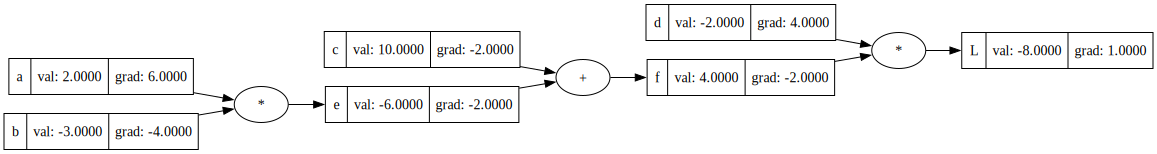

In [10]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data
c.grad = d.data
e.grad = d.data
a.grad = d.data * b.data
b.grad = d.data * a.data

draw_graph(L)

### Changing the output of the loss function

Now we can change our input parameters a small direction into the gradient & recalculate our mathmatical expression (doing the forward pass).

Changing the loss function output is one step of optimizing a neural network. The training loop looks like this:

1. Forward pass
2. Backpropagation
3. Nudge parameters
4. Repeat process


In [11]:
# change input paramters
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad

# forward pass
e = a*b
f = e + c
L = d * f

print(L.data)

-7.286496


### Neurons

![Neuron](img/back_propagation/neuron_model.jpeg)

Neurons consists of one or multiple inputs ($x_0, \dots, x_n$). Each inputs has a weight ($w_0, \dots, w_n$) which will be modified through backpropagation to make the network "learn". The neuron itself also has a bias "b" which defines how trigger happy it is. 

The dot product of all inputs and weights togethere with the bias are inserted into an acitivation functions which returns a value between two fixed constants. Each neuron has just one output value which can be passed to many different neurons in next layer.

<ins>Sigmoid activation function</ins>
- returns a value between 0 to 1

<ins>Tanh activation function</ins>
- returns a value between -1 to 1

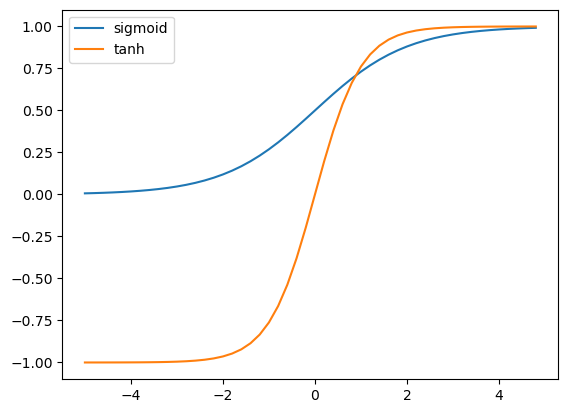

In [12]:
def sig(x):
    return 1.0 / (1.0 + np.exp(-x))

x = np.arange(-5,5,0.2)
y_sig = sig(x)
y_tanh = np.tanh(np.arange(-5,5,0.2))

plt.plot(x, y_sig, label='sigmoid')
plt.plot(x, y_tanh, label='tanh')
plt.legend()

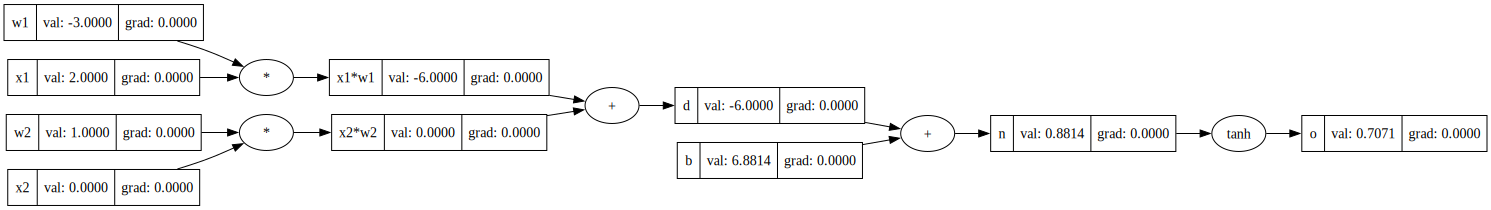

In [13]:
# creating a neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
d = x1w1 + x2w2; d.label = 'd' # dotproduct
n = d + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_graph(o)

### Backpropagation

#### Calculating the backpropagation of the neuron

Calculating the impact of change in "n" on "o"<br>
$o = \text{tanh}(n) \quad \frac{\partial o}{\partial n}[\text{tanh}(n)] = 1 - \text{tanh}(n)^2 = 1 - o^2$<br>

Calculating the impact of change in "x1" on "o"<br>
1. calculating the impact from "x1" on "x1*w1"<br>
$x1w1 = x1 * w1 \quad \frac{\partial x1w1}{\partial x1}[x1 * w1] = w1$<br>
2. applying the chain rule<br>
$\frac{\partial o}{\partial x1}[\frac{\partial o}{\partial n} * \frac{\partial x1w1}{\partial x1}] = (1 - o^2) * w1$

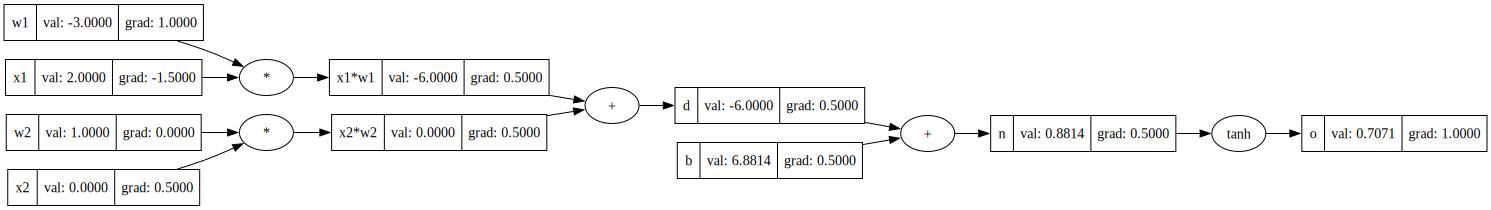

In [14]:
o.grad = 1
n.grad = 1 - o.data**2

# local derivative of plus operation is one so the gradient can be passed through
d.grad = n.grad
b.grad = n.grad
x1w1.grad = d.grad
x2w2.grad = d.grad

x1.grad = x1w1.grad * -3
w1.grad = x1w1.grad * 2
x2.grad = x2w2.grad * 1
w2.grad = x2w2.grad * 0

draw_graph(o)

To make the output "o" of the neuron go up (with the same data as input) we have to increase the value of w1 because w1 has a positive gradient. 
w2 is irrelevant because the gradient is 0.

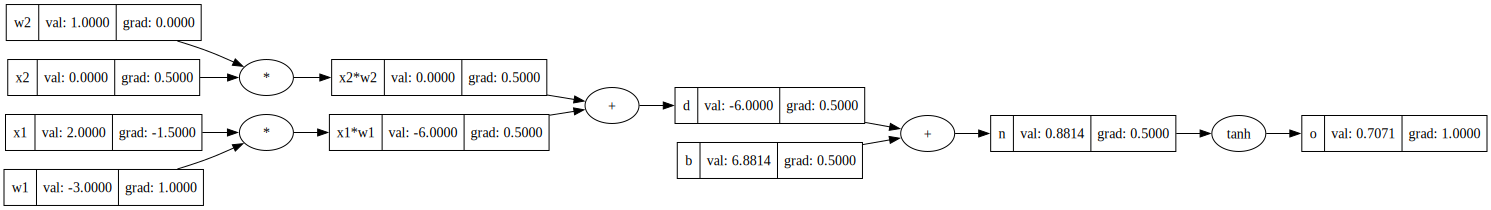

In [15]:
# recreating the neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
d = x1w1 + x2w2; d.label = 'd' # dotproduct
n = d + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

# calculate backpropagation automatically
o.backward()

draw_graph(o)

In [16]:
# class for a neuron

class Neuron:

    # nin = number of inputs (input layer)
    def __init__(self, nin):
        # initializing neuron with random values
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # dot product of all weights & inputs + bias
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # put the activiation into tanh activation function
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [17]:
# class for a layer

class Layer:

    # nin = number of inputs (input layer)
    # nout = number of neurons in the layer
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [18]:
# class for a MLP

class MLP:

    # nin = number of inputs (input layer)
    # nouts = list of sizes for each layer
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [19]:
# 3 inputs, 2 hidden layers a 4 neurons, 1 output neuron
n = MLP(3, [4, 4, 1])

# inputs - training data
xs = [
  [2.0, 3.0, -1.0], # 1.0
  [3.0, -1.0, 0.5], # -1.0
  [0.5, 1.0, 1.0], # -1.0
  [1.0, 1.0, -1.0], # 1.0
]

# labels - desired targets
ys = [1.0, -1.0, -1.0, 1.0]

In [20]:
for k in range(101):
  
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) / len(ypred)
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update weights & biasas
    for p in n.parameters():
        p.data += -0.1 * p.grad

    if k % 10 == 0:
        print(k, loss.data)

ypred

0 1.7567153160184203
10 0.14513742462230786
20 0.0489462432599616
30 0.02921650784636783
40 0.020671373039401898
50 0.015924580452378868
60 0.012915938642712909
70 0.010844138805439524
80 0.009333453920165442
90 0.008184722578969916
100 0.007282724429007038


[Value(data=0.9171870399273714),
 Value(data=-0.9215135601985983),
 Value(data=-0.9054439521940144),
 Value(data=0.9153126694797239)]